# Tilt and Compliance Corrections for OBS Data: Earthquakes
### Xiaotao Yang @ Harvard University
This notebook contains examples of compliance corrections using data downloaded from IRIS. The functions for tilt and compliance corrections are saved in a separate file: obsmaster.py.
### References:
Bell, S. W., D. W. Forsyth, & Y. Ruan (2015), Removing Noise from the Vertical Component Records of Ocean-Bottom Seismometers: Results from Year One of the Cascadia Initiative, Bull. Seismol. Soc. Am., 105(1), 300-313, doi:10.1785/0120140054.

Tian, Y., & M. H. Ritzwoller (2017), Improving ambient noise cross-correlations in the noisy ocean bottom environment of the Juan de Fuca plate, Geophys. J. Int., 210(3), 1787-1805, doi:10.1093/gji/ggx281.

Helen A Janiszewski, James B Gaherty, Geoffrey A Abers, Haiying Gao, Zachary C Eilon, Amphibious surface-wave phase-velocity measurements of the Cascadia subduction zone, Geophysical Journal International, Volume 217, Issue 3, June 2019, Pages 1929–1948, https://doi.org/10.1093/gji/ggz051

## Step 0. Import needed packages.

In [1]:
#import needed packages.
from seisgo import utils
from seisgo import obsmaster as obs
import sys
import time
import scipy
import obspy
import pyasdf
import datetime
import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
from obspy import UTCDateTime
from obspy.core import Trace
from IPython.display import clear_output
from obspy.clients.fdsn import Client
from obspy.core.event import Catalog
from obspy.geodetics.base import gps2dist_azimuth
try:
    from obspy.core.event import readEvents
except Exception as e:
    from obspy import read_events as readEvents

## Step 1. Get earthquake catalog with the specified date range.
In this example, I only use one day to get the earthquakes. The codes can be modified to work on a broader range of time for earthquake catalog. The earthquake catalog is retrieved from GCMT catalog.

In [2]:
evt_start= '2012-01-01'
evt_end = '2012-01-31'
evlon_min = -133
evlon_max = -116
evlat_min = 38
evlat_max = 52
evmag_min = 5.0
evmag_max = 10.0
evdep_min = 0
evdep_max = 100

print('retrieving earthquake catalog, may take a few minutes ...')
cat=Catalog()
t0=time.time()
cat = readEvents('http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/COMBO/combo.ndk')
print('it took '+str(time.time() - t0)+' s to get the catalog')
# cat=readEvents('./gcmtcombo.ndk')
filt1 = 'time >= %s' % evt_start
filt2 = 'time <= %s' % evt_end
cat = cat.filter(filt1, filt2)

filt1 = 'magnitude >= %s' % evmag_min
filt2 = 'magnitude <= %s' % evmag_max
cat = cat.filter(filt1, filt2)

filt1 = 'depth >= %s' % (float(evdep_min)*1000.)
filt2 = 'depth <= %s' % (float(evdep_max)*1000.)
cat = cat.filter(filt1, filt2)

if None not in [evlat_min, evlat_max, evlon_min, evlon_max]:
    filt1 = 'latitude >= %s' % evlat_min
    filt2 = 'latitude <= %s' % evlat_max
    cat = cat.filter(filt1, filt2)

    filt1 = 'longitude >= %s' % evlon_min
    filt2 = 'longitude <= %s' % evlon_max
    cat = cat.filter(filt1, filt2)

#
events=utils.qml_to_event_list(cat)


retrieving earthquake catalog, may take a few minutes ...
it took 223.8510880470276 s to get the catalog


/usr/local/anaconda3/envs/seispy/lib/python3.7/site-packages/obspy/core/util/attribdict.py:97: UserWarning: Setting attribute "preferred_mag" which is not a default attribute ("event_descriptions", "comments", "picks", "amplitudes", "focal_mechanisms", "origins", "magnitudes", "station_magnitudes", "resource_id", "event_type", "event_type_certainty", "creation_info", "preferred_origin_id", "preferred_magnitude_id", "preferred_focal_mechanism_id").
  warnings.warn(msg)
/usr/local/anaconda3/envs/seispy/lib/python3.7/site-packages/obspy/core/util/attribdict.py:97: UserWarning: Setting attribute "preferred_mag_type" which is not a default attribute ("event_descriptions", "comments", "picks", "amplitudes", "focal_mechanisms", "origins", "magnitudes", "station_magnitudes", "resource_id", "event_type", "event_type_certainty", "creation_info", "preferred_origin_id", "preferred_magnitude_id", "preferred_focal_mechanism_id").
  warnings.warn(msg)
/usr/local/anaconda3/envs/seispy/lib/python3.7/si

## Step 2. Get earthquake and station list based on the event information.
In this, we will download all earthquakes within the date range. For the purpose of this test, we narrow down the earthquake list (i.e., only the rist one for now).

In [3]:
ev=events[0] #only work on the first event for now.
print(ev)
evlon=ev['longitude']
evlat=ev['latitude']
evdep=ev['depth']

client    = Client('IRIS')
# netall="7D"
stlamin,stlamax,stlomin,stlomax= 37.0,52.0,-133.0,-116.0
preset=14400 #seconds before the origin time
offset=21600 #seconds after the origin time
starttime = ev['datetime'] - preset
endtime = ev['datetime'] + offset

pchanfound=0
try:
    sta_invP0 = client.get_stations(network='7D',station='*',channel='*H',location='*', \
                    starttime=starttime,endtime=endtime,minlatitude=stlamin,maxlatitude=stlamax, \
                    minlongitude=stlomin, maxlongitude=stlomax)

    pchanfound=1
except Exception as e:
    pchanfound == 0

staall,netall,lonall,latall,elvall,locationall=utils.sta_info_from_inv(sta_invP0)
# print(sta,netall,lon,lat,elv,location)          


OrderedDict([('number', 1), ('latitude', 51.06), ('longitude', -130.77), ('depth', 18.9), ('datetime', UTCDateTime(2012, 1, 13, 19, 46, 8, 700000)), ('magnitude', 5.0), ('magnitude_type', 'Mwc'), ('author', 'None'), ('event_id', '20120113_194608.a'), ('origin_id', ResourceIdentifier(id="smi:local/ndk/C201201131946A/origin#cmtorigin")), ('focal_mechanism', [-2070000000000000.0, -1.46e+16, 1.66e+16, -1710000000000000.0, -8180000000000000.0, 3.58e+16]), ('source_duration', ['triangle', 1.6]), ('flynn_region', 'NAN')])


IndexError: list index out of range

In [7]:
print(ev)

OrderedDict([('number', 1), ('latitude', 51.06), ('longitude', -130.77), ('depth', 18.9), ('datetime', UTCDateTime(2012, 1, 13, 19, 46, 8, 700000)), ('magnitude', 5.0), ('magnitude_type', 'Mwc'), ('author', 'None'), ('event_id', '20120113_194608.a'), ('origin_id', ResourceIdentifier(id="smi:local/ndk/C201201131946A/origin#cmtorigin")), ('focal_mechanism', [-2070000000000000.0, -1.46e+16, 1.66e+16, -1710000000000000.0, -8180000000000000.0, 3.58e+16]), ('source_duration', ['triangle', 1.6]), ('flynn_region', 'NAN')])


## Step 3. Run codes for tilt and compliance corrections.
In this step, we will call OBSMASTER functions to remove the tilt and compliance noise.

In [4]:
# get data from IRIS web service
rmresp=True #remove instrument response
# parameters for butterworth filter
samp_freq=5
pfreqmin=0.002
pfreqmax=samp_freq/2

# prefilter information used when removing instrument responses
f1 = 0.95*pfreqmin;f2=pfreqmin
if 1.05*pfreqmax > 0.48*samp_freq:
    f3 = 0.45*samp_freq
    f4 = 0.48*samp_freq
else:
    f3 = pfreqmax
    f4= 1.05*pfreqmax
pre_filt  = [f1,f2,f3,f4]

# get relationship between water depth and maximum compliance frequency.
d=np.arange(1,5051,50) #water depth
f=obs.maxcompfreq(d,iplot=False)

In [5]:
distall=[]
trZall=dict()
correctall=dict()
window=2000
overlap=0.2
taper=0.08
t0=time.time()
for i in range(len(staall)):
    ista=staall[i]
    net=netall[i]
    slon=lonall[i]
    slat=latall[i]
    selv=elvall[i]
    
    clear_output(wait=True)
    print("working on: "+net+"."+ista)
    
    """
    a. Downloading data that will be used to compute the transfer functions.
    """
    try:
        tr1,tr2,trZ,trP = obs.getdata(net,ista,starttime,endtime,samp_freq=samp_freq,
                                      plot=False,rmresp=rmresp,pre_filt=pre_filt)
    except Exception as e:
        print(e)
        continue
    
    if np.sum(np.isnan(trZ.data)) > 0 or np.sum(np.isnan(trP.data)) >0 or \
        np.sum(np.isnan(tr1.data)) >0 or np.sum(np.isnan(tr2.data)) >0:
        print('Found NaN in data. Skip!')
        continue
    
    trZall[net+"."+ista]=trZ
    
    """
    b. Call the wrapper to remove the tilt and compliance noise.
    """
    correct=obs.TCremoval_wrapper(
        tr1,tr2,trZ,trP,window=window,overlap=overlap,merge_taper=taper,
        qc_freq=[0.004, 0.2],qc_spectra=True,fig_spectra=False,
        save_spectrafig=False,fig_transfunc=False)[2]
    correctall[net+"."+ista]=correct
    
#     obs.plotcorrection(trZ,correct,freq=[0.005,0.1],
#                        size=(12,13),save=True,form='png')
        
    #get station coordinates
    dist=gps2dist_azimuth(slat,slon,evlat,evlon)
    distall.append(dist)


ta=time.time() - t0
print('all cpu times (minutes): '+str(ta/60))



working on: 7D.M08A
station 7D.M08A --> pressure channel: BDH
station 7D.M08A --> seismic channels: BH1, BH2, BHZ
  downsamping from 50 to 5
  removing response using inv for 7D.M08A.BH1
  removing response using inv for 7D.M08A.BH2
  removing response using inv for 7D.M08A.BHZ
  removing response using inv for 7D.M08A.BDH
all cpu times (minutes): 20.349244515101116


## Step 4. Plot the traces against distance.
Data from each receiver contains four traces: pressure, vertical, predicted vertical, and corrected vertical.

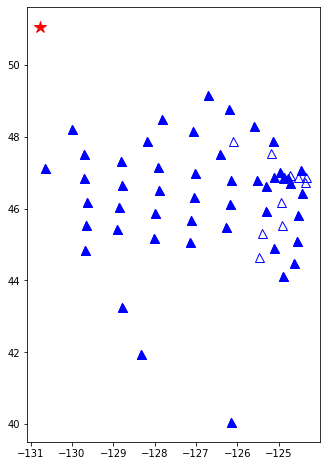

In [10]:
#plot event and station location map first.
#get receiver coordinates
rlon=np.ndarray((len(distall),))
rlat=np.ndarray((len(distall),))
allkeys=list(trZall.keys())
netstaall=[]
for i in range(len(staall)):
    netstaall.append(netall[i]+"."+staall[i])
    
for j in range(len(distall)):
    idx=netstaall.index(allkeys[j])
    rlon[j]=lonall[idx]
    rlat[j]=latall[idx]
    
plt.figure(figsize=(8, 8))
ax=plt.subplot()
plt.plot(evlon,evlat,'*r', markersize=12)
plt.plot(rlon,rlat,'^b', markersize=9)
plt.plot(lonall,latall,'^b', markersize=9,markerfacecolor='None')
ax.set_aspect(aspect=np.cos(np.mean([stlamin,stlamax])))
plt.savefig(ev['event_id']+'_receivermapwithdata.png')
plt.show()


plotting ...


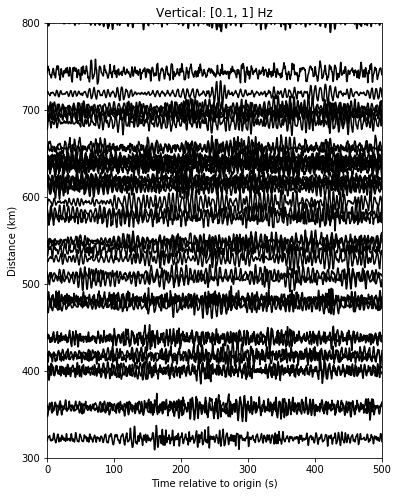

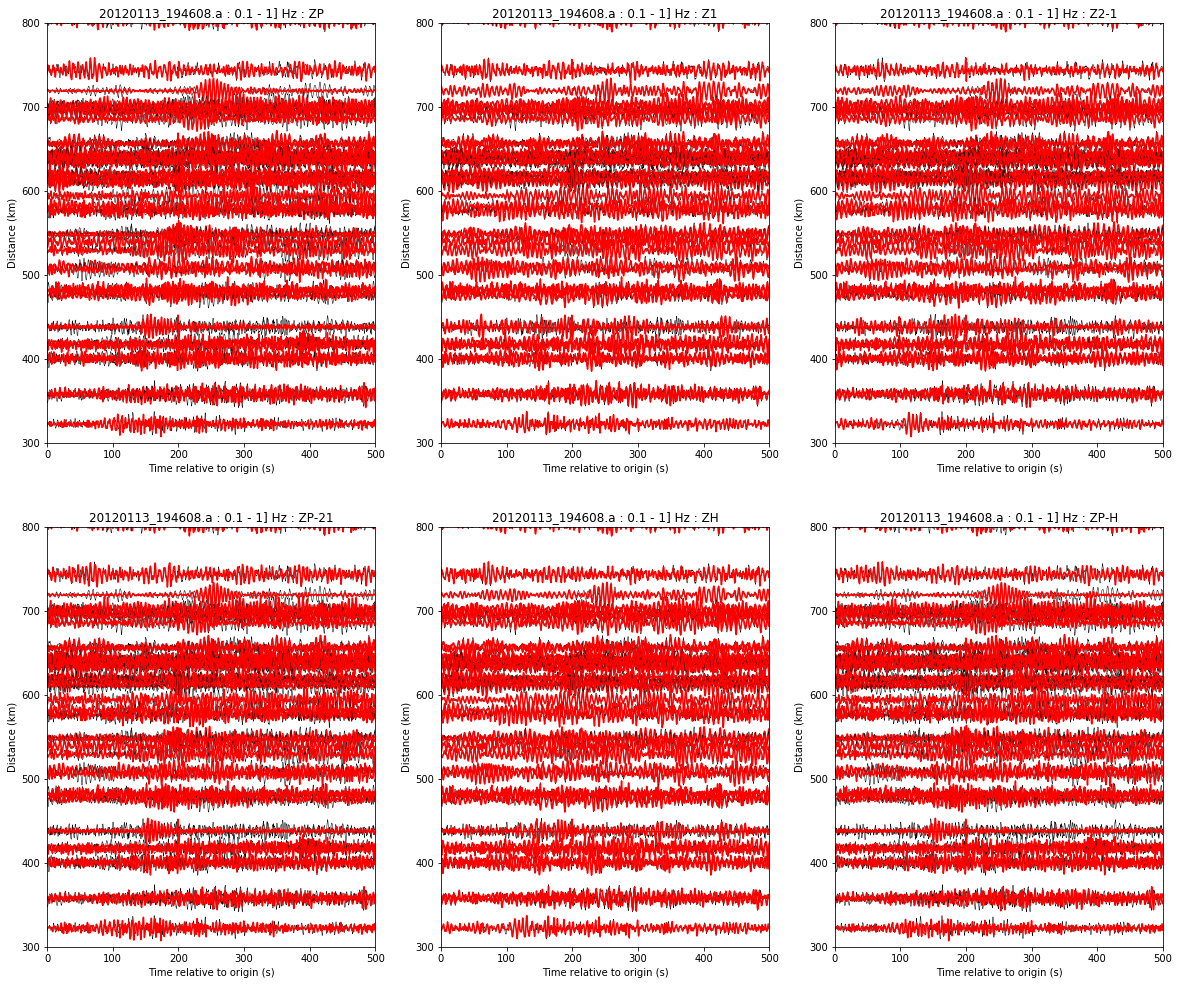

In [11]:
#plotting
print("plotting ...")
pfreqmin=0.1
pfreqmax=1
xlimit=[0, 500]
ylimit=[300, 800]
scale=15
figsize=[6,8]
plt.figure(figsize=figsize)
allkeys=list(trZall.keys())

for i in range(len(distall)):
    tc=trZall[allkeys[i]].copy()
    tt=tc.times();
    if len(xlimit)>0:
        imin = np.searchsorted(tt,xlimit[0]+preset,side="left")
        imax = np.searchsorted(tt,xlimit[1]+preset,side="left")
    else:
        imin=0
        imax=len(tc.data)-1
    tc.filter('bandpass',freqmin=pfreqmin,freqmax=pfreqmax,zerophase=True)
    dtemp=tc.data/np.max(np.abs(tc.data[imin:imax]))
    plt.plot(tt-preset,distall[i][0]/1000 + scale*dtemp,'k')
    plt.xlim(xlimit)
    plt.ylim(ylimit)
    plt.xlabel('Time relative to origin (s)')
    plt.ylabel('Distance (km)')
    plt.title('Vertical: ['+str(pfreqmin)+', '+str(pfreqmax)+'] Hz')

plt.savefig(ev['event_id']+'_rawmoveout'+str(pfreqmin)+'_'+str(pfreqmax)+'Hz.png')
#plt.close()    

plt.figure(figsize=[20,17])
ckeys=list(correctall[allkeys[0]].keys())
for c in range(len(ckeys)):
    plt.subplot(2,3,c+1)
    plt.title(ev['event_id']+' : '+str(pfreqmin)+' - '+str(pfreqmax)+'] Hz : '+ckeys[c])
    
    for i in range(len(distall)):
        tc=trZall[allkeys[i]].copy()
        tcZ=trZall[allkeys[i]].copy()
        tt=tc.times();
        tc.data=np.squeeze(correctall[allkeys[i]][ckeys[c]])
        if len(xlimit)>0:
            imin = np.searchsorted(tt,xlimit[0]+preset,side="left")
            imax = np.searchsorted(tt,xlimit[1]+preset,side="left")
        else:
            imin=0
            imax=len(tc.data)-1
        tc.filter('bandpass',freqmin=pfreqmin,freqmax=pfreqmax,zerophase=True)
        tcZ.filter('bandpass',freqmin=pfreqmin,freqmax=pfreqmax,zerophase=True)
        dtemp=tc.data/np.max(np.abs(tc.data[imin:imax]))
        dtempZ=tcZ.data/np.max(np.abs(tcZ.data[imin:imax]))
        plt.plot(tt-preset,distall[i][0]/1000 + scale*dtempZ,'k',lw=0.5)
        plt.plot(tt-preset,distall[i][0]/1000 + scale*dtemp,'r')
        plt.xlim(xlimit)
        plt.ylim(ylimit)
        plt.xlabel('Time relative to origin (s)')
        plt.ylabel('Distance (km)')

plt.savefig(ev['event_id']+'_corrected'+str(pfreqmin)+'_'+str(pfreqmax)+'Hz.png',orientation='landscape')